## Import

In [ ]:
# Import libraries
!pip install torchmetrics

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchmetrics
from torchsummary import summary
from time import time

print('\n')
print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
device = torch.device("cuda:0")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())} - {device} ")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 515, in _det

## Data Loading

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # this also converts from uint8 to float and scales from 0-255 to 0-1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize pixel intensities to 0.5 mean and 0.5 standard deviation on all 3 channels
     # torchvision.transforms.Pad(padding=4, fill=0, padding_mode='constant'), # don't need to pad, because the RandomCrop can allso do it
     torchvision.transforms.RandomHorizontalFlip(p=0.5), # whenever i load an image there's 50% i load the original and .5 chance that the flip (this is augmentation)
     torchvision.transforms.RandomCrop((32, 32), padding=4, fill=0, padding_mode='constant') # add 4 pixels to each sides -> 40x40 and then take a random 32x32 from it (very aggresive)
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # load the training images ; transform execute the previsouly defined transform function
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) # load the testing images

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, # (3X32X32) -> (64X3X32X32) , because the batch size is 64
                                          shuffle=True, num_workers=2) # batch the training images and shuffle ; loading is always happens on the cpu
                                                                       # them before each epoch so there are different combination of images in the batches of the next epoch
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2) # batch the testing images 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Training loop

In [ ]:
def train(model):
  losses = []
  batch_train_accuracies = []
  epoch_train_accuracies = []
  epoch_val_accuracies = []

  train_accuracy_metric = torchmetrics.Accuracy()
  val_accuracy_metric = torchmetrics.Accuracy()

  for epoch in range(EPOCHS):
    epoch_start = time()
    # training
    print('TRAINING EPOCH: ', epoch + 1)
    model.train()
    for images, labels in trainloader: # the train loader is an iterator, batch of an images and the corresponding labels
      images = images.to(device) # put the model on the gpu
      gpu_labels = labels.to(device) # put the labels on the gpu as well (because of the backpropagation)
      optimizer.zero_grad() # every batch start with zero gradient (clear the gradient cache)
      outputs = model(images) # this is the prediction
      loss = criterion(outputs, gpu_labels) # calculate the loss function of the prediction (categorical cross entropy is the loss function)
      loss.backward() # backward propagation
      optimizer.step() # change the weights based on the gradient

      outputs = F.softmax(outputs)
      outputs = outputs.to('cpu') # torch metrics is on the cpu so i put it back there

      batch_acc = train_accuracy_metric(outputs, labels)
      batch_train_accuracies.append(batch_acc)
      losses.append(loss.to('cpu').detach())
    epoch_train_acc = train_accuracy_metric.compute() # all of the batches
    epoch_train_accuracies.append(epoch_train_acc)

    train_end = time()
    print(f'Training took {train_end - epoch_start}', ' seconds.')
    # validation
    model.eval() # it is important to put the model into eval mode, because we're testing it
    for images, labels in testloader:
      images = images.to(device)
      outputs = model(images)

      outputs = F.softmax(outputs)
      outputs = outputs.to('cpu')

      val_accuracy_metric(outputs, labels)
    val_acc = val_accuracy_metric.compute()
    epoch_val_accuracies.append(val_acc)
    val_end = time()
    print(f'Validation took {val_end - train_end}', ' seconds.')
    print('Train accuracy: ', epoch_train_acc.numpy())
    print('Validation accuracy: ', val_acc.numpy())
    print()

  fig, axes = plt.subplots(2,2, figsize=(20,10))
  ax1 = axes[0, 0]
  ax2 = axes[1, 0]
  ax3 = axes[0, 1]
  ax4 = axes[1, 1]
  ax1.plot(batch_train_accuracies)
  ax2.plot(epoch_train_accuracies)
  ax3.plot(epoch_val_accuracies)
  ax4.plot(losses)
  #ax1.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
  ax1.set_title('batch_train_accuracies')
  #ax2.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
  ax2.set_title('epoch_train_accuracies')
  #ax3.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
  ax3.set_title('epoch_val_accuracies')
  #ax4.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
  ax4.set_title('losses')
  plt.show() 

## Freezing the parameters

First I will try SGD with momentum with default parameters in the sense of learning rate and momentum. Here I only train the classification layer, all the convolutional parameters are frozen.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 16.622737646102905  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.485429525375366  seconds.
Train accuracy:  0.57532
Validation accuracy:  0.5868

TRAINING EPOCH:  2
Training took 16.42619800567627  seconds.
Validation took 4.4905617237091064  seconds.
Train accuracy:  0.58856
Validation accuracy:  0.59485

TRAINING EPOCH:  3
Training took 17.473234176635742  seconds.
Validation took 3.4285497665405273  seconds.
Train accuracy:  0.5949733
Validation accuracy:  0.5973667

TRAINING EPOCH:  4
Training took 16.77294135093689  seconds.
Validation took 3.4643614292144775  seconds.
Train accuracy:  0.59854
Validation accuracy:  0.6

TRAINING EPOCH:  5
Training took 16.53007173538208  seconds.
Validation took 3.4006564617156982  seconds.
Train accuracy:  0.600916
Validation accuracy:  0.60046

TRAINING EPOCH:  6
Training took 16.676926851272583  seconds.
Validation took 3.7923238277435303  seconds.
Train accuracy:  0.60236335
Validation accuracy:  0.60158336

TRAINING EPOCH:  7
Training took 16.857526540756226  seconds.
Validation took 3.37

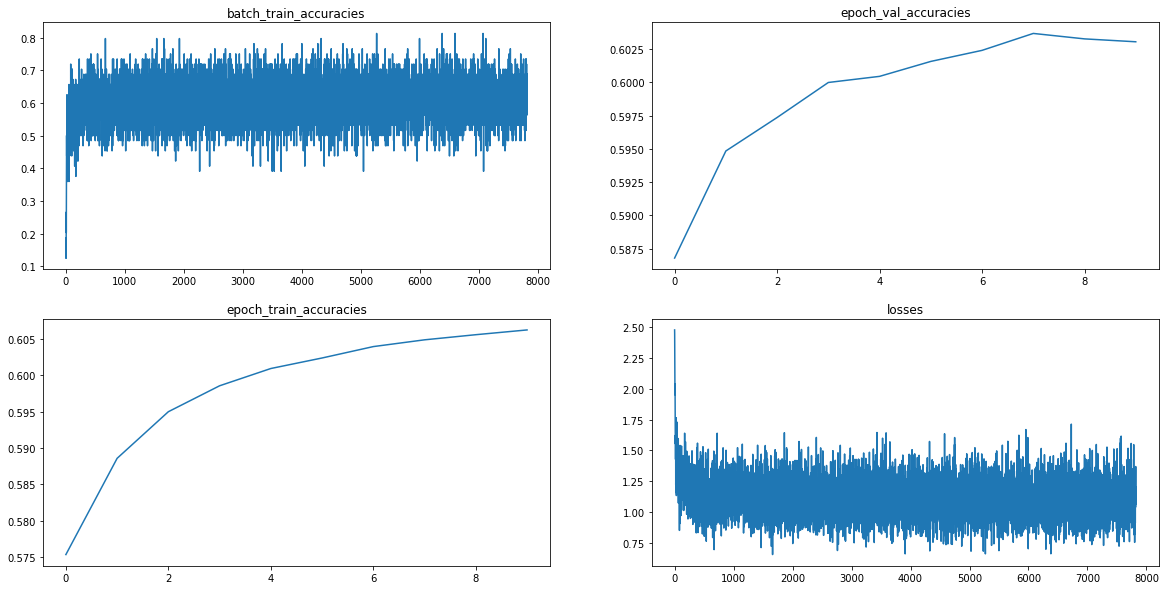

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = nn.Linear(512, 10)
model.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=0, nesterov=False)
train(model)

Not so good results (at least it's way better than randomly guessing...). My idea is to build a classification layer (not just a linear one) and let's see if it shows any improvement.

## Classification layer (FCN)

In [ ]:
class FCNet(nn.Module):
  def __init__(self):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(512, 256) 
    self.fc2 = nn.Linear(256, 128) 
    self.fc3 = nn.Linear(128, 10) 

    self.activ = nn.ReLU()

  def forward(self, x): 
    x = self.fc1(x) 
    x = self.activ(x) 
    x = self.fc2(x)
    x = self.activ(x) 
    x = self.fc3(x) 

    return x

This is my fully connected classification layer above. I had to start with 512 neurons as it is the result of the pooling (after flattening) and then I made two hidden layers.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 17.18468999862671  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.4674906730651855  seconds.
Train accuracy:  0.54496
Validation accuracy:  0.5981

TRAINING EPOCH:  2
Training took 17.183767557144165  seconds.
Validation took 3.4705069065093994  seconds.
Train accuracy:  0.57868
Validation accuracy:  0.6091

TRAINING EPOCH:  3
Training took 16.909305810928345  seconds.
Validation took 3.506362199783325  seconds.
Train accuracy:  0.59529334
Validation accuracy:  0.6149333

TRAINING EPOCH:  4
Training took 16.653282165527344  seconds.
Validation took 3.4573206901550293  seconds.
Train accuracy:  0.60618
Validation accuracy:  0.61665

TRAINING EPOCH:  5
Training took 16.62731647491455  seconds.
Validation took 3.4907066822052  seconds.
Train accuracy:  0.61368
Validation accuracy:  0.61954

TRAINING EPOCH:  6
Training took 16.63834547996521  seconds.
Validation took 3.4444806575775146  seconds.
Train accuracy:  0.6200233
Validation accuracy:  0.6207833

TRAINING EPOCH:  7
Training took 16.777902126312256  seconds.
Validation took 3.480

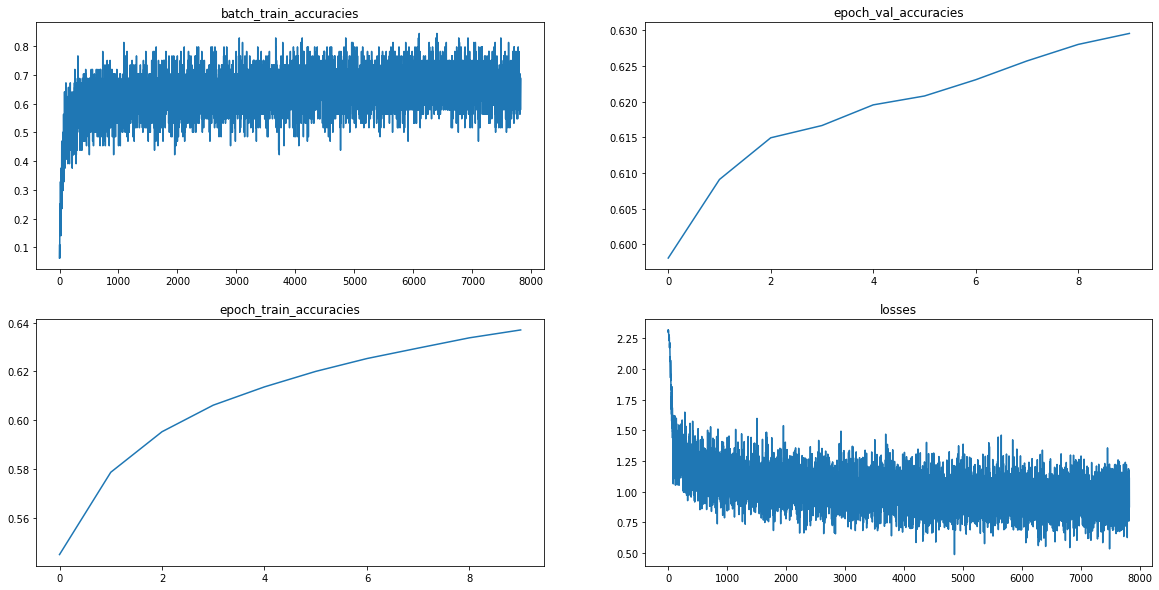

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=0, nesterov=False)
train(model)

To be honest I was hoping for more improvement but at least some percentage in the accuracy.<br>
Let's try it with the Adam optimizer (default parameters) and I will tweak a bit the classification layer. My intuition is that we can increase the number of neurons.

In [ ]:
class FCNet(nn.Module):
  def __init__(self):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(512, 1024) 
    self.fc2 = nn.Linear(1024, 256) 
    self.fc3 = nn.Linear(256, 10) 

    self.activ = nn.ReLU()

  def forward(self, x): 
    x = self.fc1(x) 
    x = self.activ(x) 
    x = self.fc2(x)
    x = self.activ(x) 
    x = self.fc3(x) 

    return x

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0, amsgrad=False)
summary(model, (3, 32, 32))
# just to check the new architecture
# train(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 17.313459157943726  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.548772096633911  seconds.
Train accuracy:  0.58642
Validation accuracy:  0.6163

TRAINING EPOCH:  2
Training took 16.909623861312866  seconds.
Validation took 3.506791114807129  seconds.
Train accuracy:  0.60942
Validation accuracy:  0.6207

TRAINING EPOCH:  3
Training took 17.286842584609985  seconds.
Validation took 3.5333950519561768  seconds.
Train accuracy:  0.62234664
Validation accuracy:  0.6252667

TRAINING EPOCH:  4
Training took 17.01981830596924  seconds.
Validation took 3.552661895751953  seconds.
Train accuracy:  0.631845
Validation accuracy:  0.631125

TRAINING EPOCH:  5
Training took 16.96374225616455  seconds.
Validation took 3.4607431888580322  seconds.
Train accuracy:  0.639536
Validation accuracy:  0.63482

TRAINING EPOCH:  6
Training took 17.184699058532715  seconds.
Validation took 3.5088603496551514  seconds.
Train accuracy:  0.64619666
Validation accuracy:  0.63715

TRAINING EPOCH:  7
Training took 17.44824528694153  seconds.
Validation took 3.8

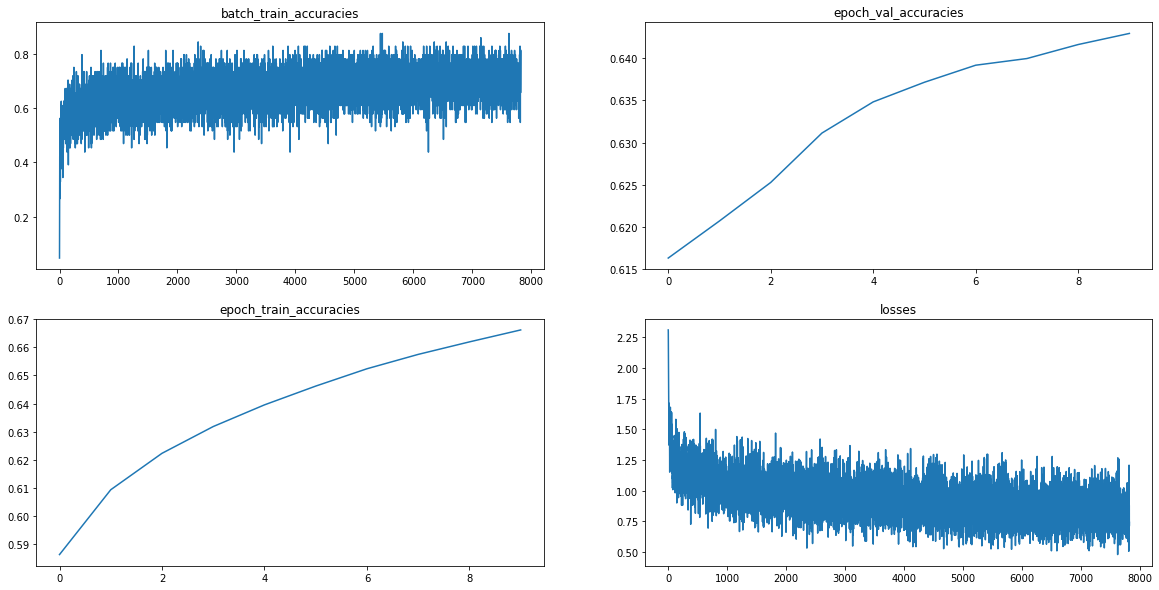

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0, amsgrad=False)
train(model)

Just a little improvement again. Maybe because of the optimizer but the classification layer was more complex too. We can have an intuition from the obtained plots that maybe with more epochs we can still increase the accuracy but I want to experiments with other stuffs as well so I am gonna leave this as it is now.<br>
Let's try to increase the batch size.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 17.018872261047363  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.434415102005005  seconds.
Train accuracy:  0.58896
Validation accuracy:  0.6149

TRAINING EPOCH:  2
Training took 16.994840621948242  seconds.
Validation took 3.4273788928985596  seconds.
Train accuracy:  0.60979
Validation accuracy:  0.6206

TRAINING EPOCH:  3
Training took 17.180678367614746  seconds.
Validation took 3.6215147972106934  seconds.
Train accuracy:  0.62340665
Validation accuracy:  0.6264667

TRAINING EPOCH:  4
Training took 17.679521560668945  seconds.
Validation took 3.439897060394287  seconds.
Train accuracy:  0.632985
Validation accuracy:  0.6305

TRAINING EPOCH:  5
Training took 17.026156425476074  seconds.
Validation took 3.4692912101745605  seconds.
Train accuracy:  0.641248
Validation accuracy:  0.6343

TRAINING EPOCH:  6
Training took 16.87052583694458  seconds.
Validation took 3.3981244564056396  seconds.
Train accuracy:  0.64774
Validation accuracy:  0.6377

TRAINING EPOCH:  7
Training took 16.792194366455078  seconds.
Validation took 3.41795

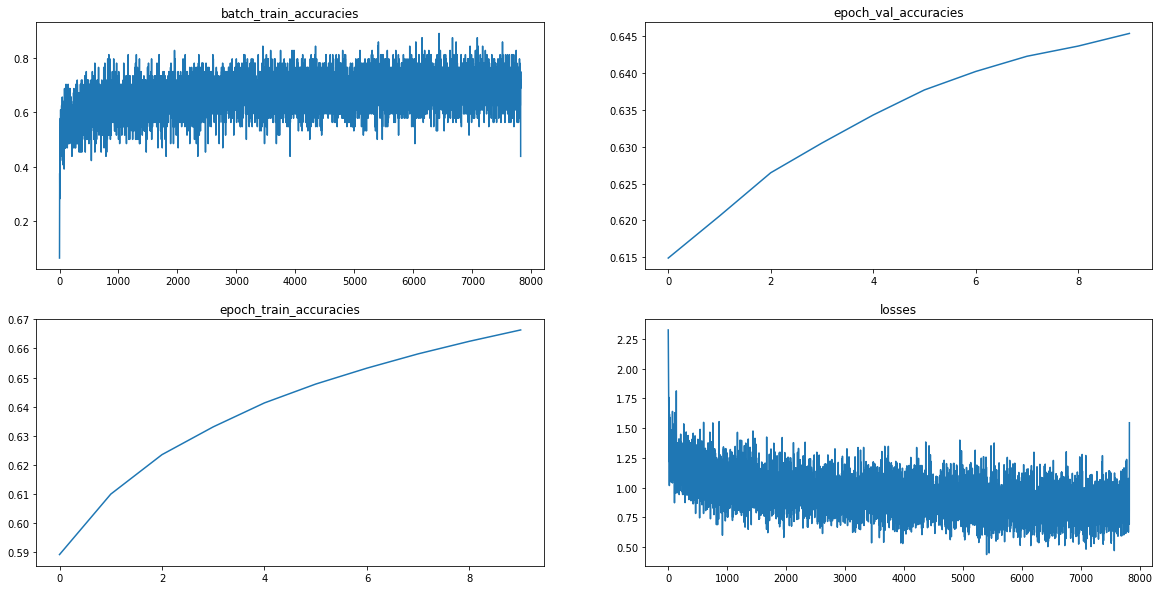

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0, amsgrad=False)
train(model)

My conclusion so far is that if we freeze all the parameters of the convolutional layer the Adam optimizer outperforms the SGD with Momentum approach, but the latter obviously needs more tweaking. In addition we can increase the accuracy if we change the classification layer into a more complex FCNN. I cannot obtain significant improvement by increasing the batch size, nevertheless it was somewhat better.

## Augmentation experiments

My idea is that maybe if we just train the classification layer and freeze all the convolutional layers it is not so effective to transform aggressively the images. My understanding is that it helps mostly to train the convolutional layer (so it can see different patterns, try to recognise those patterns/features). But right now we're just training the classification layer, it learned some features already by the convolutional layers of the VGG. But this is just an idea. So let's try to change the augmentation. I will change the probability of doing the horizontal flip and remove the cropping.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     # torchvision.transforms.Pad(padding=4, fill=0, padding_mode='constant'), # removed random crop for this experiment
     torchvision.transforms.RandomHorizontalFlip(p=0.3) # decreased the probability
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2) 
                                                                      
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 12.316869497299194  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 2.6265618801116943  seconds.
Train accuracy:  0.6296
Validation accuracy:  0.6543

TRAINING EPOCH:  2
Training took 12.055383443832397  seconds.
Validation took 2.579084873199463  seconds.
Train accuracy:  0.65975
Validation accuracy:  0.6638

TRAINING EPOCH:  3
Training took 12.162320137023926  seconds.
Validation took 2.637810468673706  seconds.
Train accuracy:  0.67954665
Validation accuracy:  0.6677333

TRAINING EPOCH:  4
Training took 12.216491460800171  seconds.
Validation took 2.597402334213257  seconds.
Train accuracy:  0.69644
Validation accuracy:  0.67175

TRAINING EPOCH:  5
Training took 12.140156507492065  seconds.
Validation took 2.598825454711914  seconds.
Train accuracy:  0.712036
Validation accuracy:  0.67346

TRAINING EPOCH:  6
Training took 12.01824164390564  seconds.
Validation took 2.4995453357696533  seconds.
Train accuracy:  0.72704667
Validation accuracy:  0.6734667

TRAINING EPOCH:  7
Training took 12.072231531143188  seconds.
Validation took 2.4

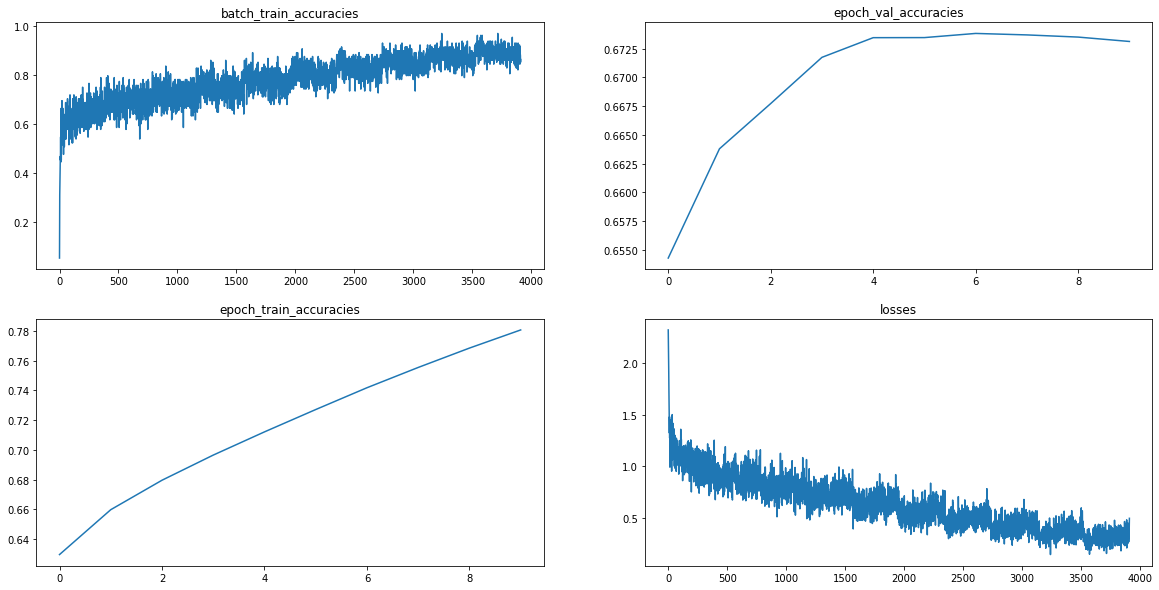

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0, amsgrad=False)

train(model)

The best result so far, but clearly overfitting. Also it is not good sign that the test accuracy stopped increasing but maybe it can go 'back on track' by increasing the epochs. My idea is to simplify the classification layer by decreasing the number of neurons in it to avoid overfitting. 

In [ ]:
class FCNet(nn.Module):
  def __init__(self):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(512, 256) 
    self.fc2 = nn.Linear(256, 128) 
    self.fc3 = nn.Linear(128, 10) 

    self.activ = nn.ReLU()

  def forward(self, x): 
    x = self.fc1(x) 
    x = self.activ(x) 
    x = self.fc2(x)
    x = self.activ(x) 
    x = self.fc3(x) 

    return x

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 12.190603017807007  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 2.52868914604187  seconds.
Train accuracy:  0.61788
Validation accuracy:  0.6551

TRAINING EPOCH:  2
Training took 11.820790767669678  seconds.
Validation took 2.4992918968200684  seconds.
Train accuracy:  0.64659
Validation accuracy:  0.6579

TRAINING EPOCH:  3
Training took 11.923084020614624  seconds.
Validation took 2.4659812450408936  seconds.
Train accuracy:  0.66358
Validation accuracy:  0.66253334

TRAINING EPOCH:  4
Training took 11.739324808120728  seconds.
Validation took 2.5053486824035645  seconds.
Train accuracy:  0.67665
Validation accuracy:  0.664975

TRAINING EPOCH:  5
Training took 12.038093090057373  seconds.
Validation took 2.5702288150787354  seconds.
Train accuracy:  0.687784
Validation accuracy:  0.66764

TRAINING EPOCH:  6
Training took 11.815999031066895  seconds.
Validation took 2.5105865001678467  seconds.
Train accuracy:  0.69783336
Validation accuracy:  0.6699

TRAINING EPOCH:  7
Training took 11.807954549789429  seconds.
Validation took 2.5

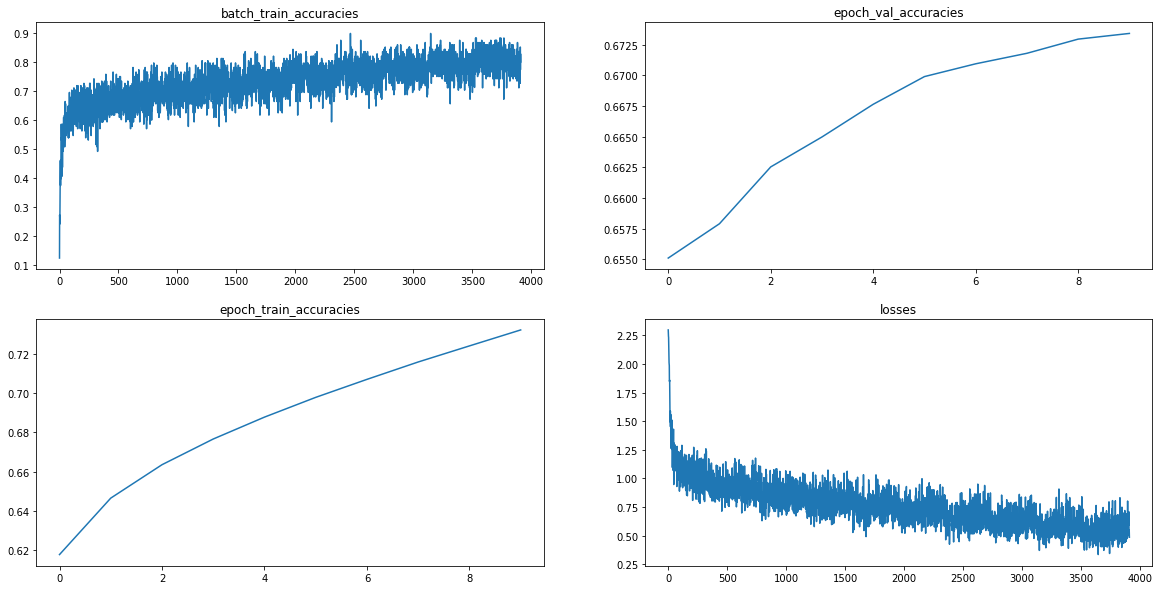

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=0, amsgrad=False)

train(model)

Unfortunately I could only decrease the test error, at least it is not overfitting but the test result is the same.

## Unfreeze the layers

First do not forget to load again the images with the first augmentation approach. Now during backpropagation we update the parameters of the convolutional layers too and use the VGG for initialization, that might improve the results.<br>

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # this also converts from uint8 to float and scales from 0-255 to 0-1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize pixel intensities to 0.5 mean and 0.5 standard deviation on all 3 channels
     # torchvision.transforms.Pad(padding=4, fill=0, padding_mode='constant'), # don't need to pad, because the RandomCrop can allso do it
     torchvision.transforms.RandomHorizontalFlip(p=0.5), # whenever i load an image there's 50% i load the original and .5 chance that the flip (this is augmentation)
     torchvision.transforms.RandomCrop((32, 32), padding=4, fill=0, padding_mode='constant') # add 4 pixels to each sides -> 40x40 and then take a random 32x32 from it (very aggresive)
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # load the training images ; transform execute the previsouly defined transform function
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) # load the testing images

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, # (3X32X32) -> (64X3X32X32) , because the batch size is 64
                                          shuffle=True, num_workers=2) # batch the training images and shuffle ; loading is always happens on the cpu
                                                                       # them before each epoch so there are different combination of images in the batches of the next epoch
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2) # batch the testing images 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's start with the SGD with Momentum approach.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 28.124140739440918  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.4201231002807617  seconds.
Train accuracy:  0.7326
Validation accuracy:  0.8078

TRAINING EPOCH:  2
Training took 28.240435361862183  seconds.
Validation took 3.4106996059417725  seconds.
Train accuracy:  0.784
Validation accuracy:  0.8193

TRAINING EPOCH:  3
Training took 28.475072622299194  seconds.
Validation took 3.3816168308258057  seconds.
Train accuracy:  0.8100333
Validation accuracy:  0.8292

TRAINING EPOCH:  4
Training took 28.484466314315796  seconds.
Validation took 3.375049591064453  seconds.
Train accuracy:  0.82785
Validation accuracy:  0.8379

TRAINING EPOCH:  5
Training took 28.661715030670166  seconds.
Validation took 3.430438995361328  seconds.
Train accuracy:  0.84132
Validation accuracy:  0.84334

TRAINING EPOCH:  6
Training took 28.60220170021057  seconds.
Validation took 3.3978984355926514  seconds.
Train accuracy:  0.8523933
Validation accuracy:  0.8495167

TRAINING EPOCH:  7
Training took 28.603116273880005  seconds.
Validation took 3.38705849

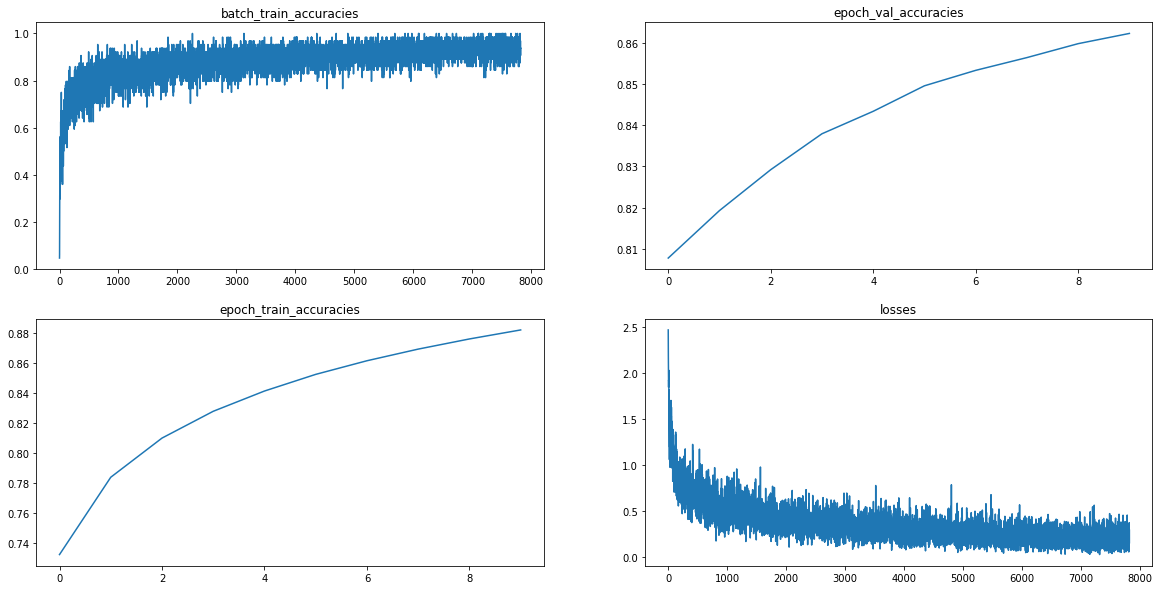

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = nn.Linear(512, 10)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)

train(model)

Indeed, there is a massive improvement if we unfreeze the convolutional layers. Let's try the Adam, maybe it can outperform the SGD here too.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 29.708963632583618  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.749093532562256  seconds.
Train accuracy:  0.3444
Validation accuracy:  0.5215

TRAINING EPOCH:  2
Training took 31.150163888931274  seconds.
Validation took 3.772575855255127  seconds.
Train accuracy:  0.50262
Validation accuracy:  0.62445

TRAINING EPOCH:  3
Training took 29.96630072593689  seconds.
Validation took 3.418036699295044  seconds.
Train accuracy:  0.58366
Validation accuracy:  0.6712667

TRAINING EPOCH:  4
Training took 30.5431489944458  seconds.
Validation took 3.427891492843628  seconds.
Train accuracy:  0.63311
Validation accuracy:  0.696975

TRAINING EPOCH:  5
Training took 30.5266330242157  seconds.
Validation took 3.422654628753662  seconds.
Train accuracy:  0.667584
Validation accuracy:  0.7159

TRAINING EPOCH:  6
Training took 30.422564268112183  seconds.
Validation took 3.483386278152466  seconds.
Train accuracy:  0.69384664
Validation accuracy:  0.73118335

TRAINING EPOCH:  7
Training took 30.435910940170288  seconds.
Validation took 3.38898324

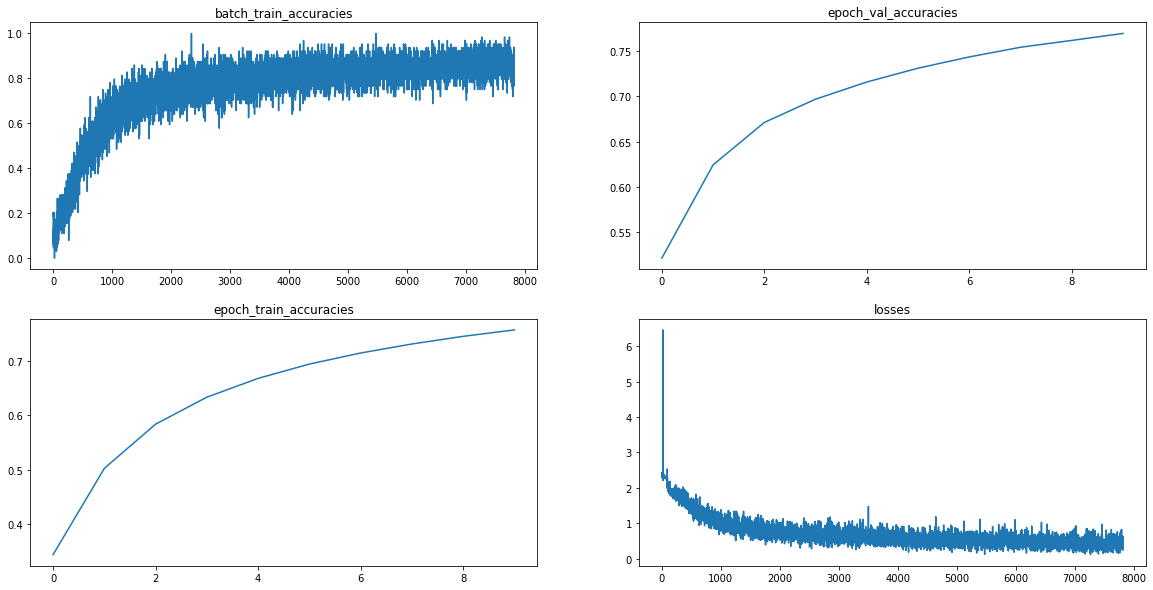

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = nn.Linear(512, 10)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

train(model)

The SGD with Momentum seems to be a better approach if we train the convolutional layers too with the given learning rates.

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
class FCNet(nn.Module):
  def __init__(self):
    super(FCNet, self).__init__()
    self.fc1 = nn.Linear(512, 256) 
    self.fc2 = nn.Linear(256, 128) 
    self.fc3 = nn.Linear(128, 10) 

    self.activ = nn.ReLU()

  def forward(self, x): 
    x = self.fc1(x) 
    x = self.activ(x) 
    x = self.fc2(x)
    x = self.activ(x) 
    x = self.fc3(x) 

    return x

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

summary(model, (3, 32, 32))
# train(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

Well that's not too much difference in the trainable parameters, let's try with a slightly more complex classification layer. I made that earlier but didn't use it yet when all the parameters were trainable.

TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 27.682971000671387  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.4974777698516846  seconds.
Train accuracy:  0.71106
Validation accuracy:  0.7484

TRAINING EPOCH:  2
Training took 27.928470611572266  seconds.
Validation took 3.5059685707092285  seconds.
Train accuracy:  0.76846
Validation accuracy:  0.78805

TRAINING EPOCH:  3
Training took 28.072097063064575  seconds.
Validation took 3.46319842338562  seconds.
Train accuracy:  0.79868
Validation accuracy:  0.8053333

TRAINING EPOCH:  4
Training took 28.41909885406494  seconds.
Validation took 3.69256854057312  seconds.
Train accuracy:  0.81925
Validation accuracy:  0.820775

TRAINING EPOCH:  5
Training took 28.43215537071228  seconds.
Validation took 3.470355987548828  seconds.
Train accuracy:  0.83378
Validation accuracy:  0.83112

TRAINING EPOCH:  6
Training took 28.64499068260193  seconds.
Validation took 3.531921625137329  seconds.
Train accuracy:  0.84536
Validation accuracy:  0.8376

TRAINING EPOCH:  7
Training took 28.63007140159607  seconds.
Validation took 3.4475641250610

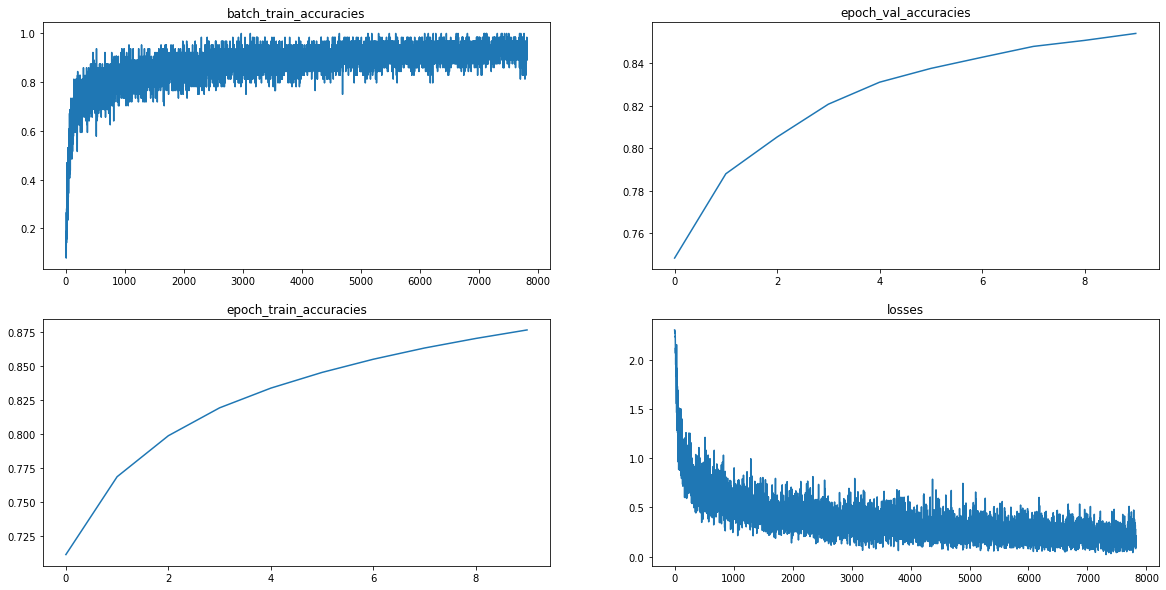

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)

train(model)

Pretty much the same or it was slightly better with the linear classification layer.

## Augmentations again

Padding and Gaussian Blur. Just experimenting...

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     torchvision.transforms.Pad(padding=4, fill=0, padding_mode='constant'),
     torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomCrop((32, 32), padding=4, fill=0, padding_mode='constant'),
     torchvision.transforms.GaussianBlur(kernel_size=(5, 9))
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                          shuffle=True, num_workers=2) 
                                                                       
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)  

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 36.39591670036316  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 6.208441972732544  seconds.
Train accuracy:  0.57634
Validation accuracy:  0.6988

TRAINING EPOCH:  2
Training took 36.17337465286255  seconds.
Validation took 6.267269611358643  seconds.
Train accuracy:  0.6478
Validation accuracy:  0.71215

TRAINING EPOCH:  3
Training took 36.3501238822937  seconds.
Validation took 6.2492687702178955  seconds.
Train accuracy:  0.6834267
Validation accuracy:  0.72713333

TRAINING EPOCH:  4
Training took 36.962096214294434  seconds.
Validation took 6.145833492279053  seconds.
Train accuracy:  0.70724
Validation accuracy:  0.738825

TRAINING EPOCH:  5
Training took 36.21870517730713  seconds.
Validation took 6.14390754699707  seconds.
Train accuracy:  0.72488
Validation accuracy:  0.7469

TRAINING EPOCH:  6
Training took 36.31759524345398  seconds.
Validation took 6.078199625015259  seconds.
Train accuracy:  0.73914665
Validation accuracy:  0.75525

TRAINING EPOCH:  7
Training took 35.955464601516724  seconds.
Validation took 6.109398365

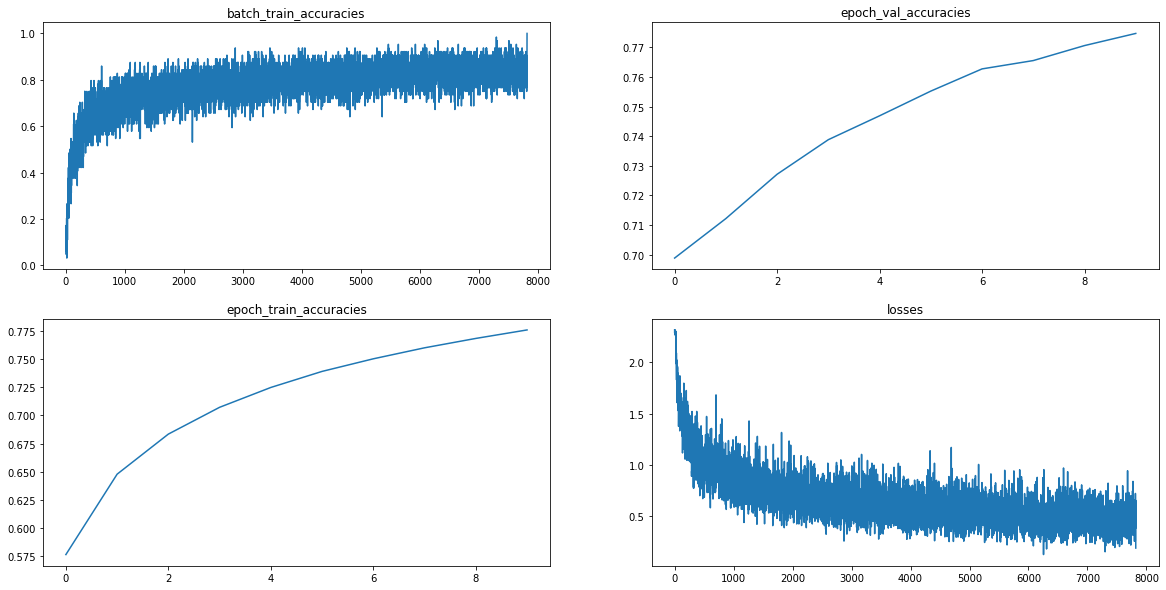

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = FCNet().to(device)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)

train(model)

Finally let's try that less aggressive setup which was good when I trained only the classification layer. I will use the linear classification layer now because I consider that the best approach so far.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     torchvision.transforms.Pad(padding=4, fill=0, padding_mode='constant'), # lets keep padding now but remove the randomcrop
     torchvision.transforms.RandomHorizontalFlip(p=0.3) # decreased the probability
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2) 
                                                                      
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


TRAINING EPOCH:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training took 39.961198568344116  seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation took 3.5424256324768066  seconds.
Train accuracy:  0.7365
Validation accuracy:  0.7877

TRAINING EPOCH:  2
Training took 40.225786447525024  seconds.
Validation took 3.5616142749786377  seconds.
Train accuracy:  0.79723
Validation accuracy:  0.8121

TRAINING EPOCH:  3
Training took 40.452139377593994  seconds.
Validation took 3.526177406311035  seconds.
Train accuracy:  0.8296533
Validation accuracy:  0.8259

TRAINING EPOCH:  4
Training took 40.760069370269775  seconds.
Validation took 3.520982265472412  seconds.
Train accuracy:  0.851245
Validation accuracy:  0.836425

TRAINING EPOCH:  5
Training took 40.79562020301819  seconds.
Validation took 3.5425453186035156  seconds.
Train accuracy:  0.867528
Validation accuracy:  0.84564

TRAINING EPOCH:  6
Training took 40.946696043014526  seconds.
Validation took 3.507739782333374  seconds.
Train accuracy:  0.88019335
Validation accuracy:  0.85071665

TRAINING EPOCH:  7
Training took 40.951387882232666  seconds.
Validation took 3.4

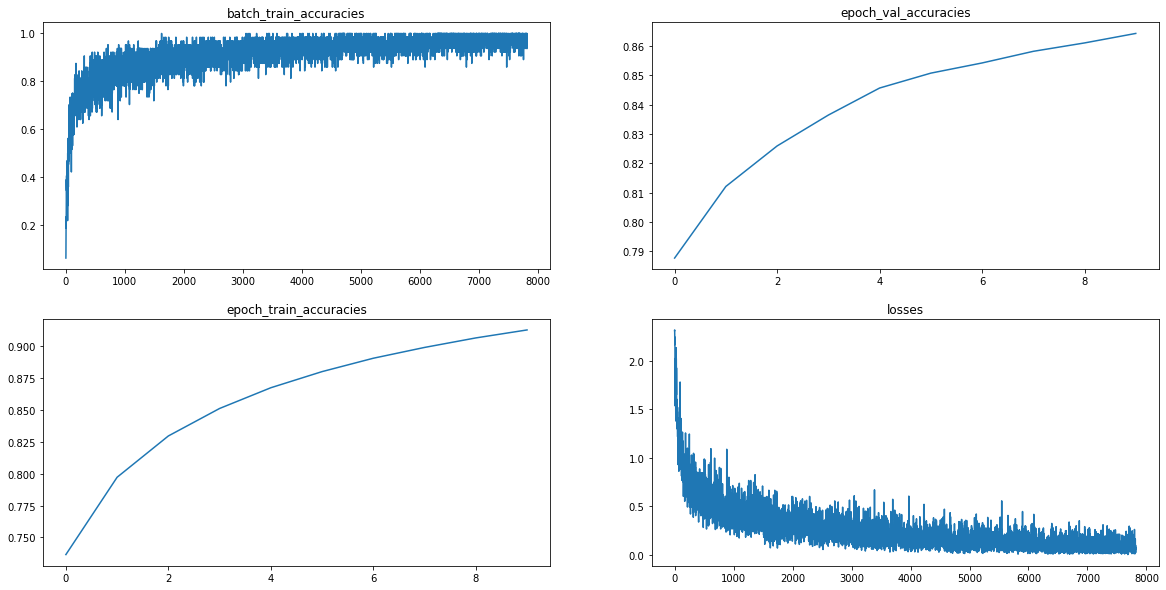

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()

model = torchvision.models.vgg16(pretrained=True, progress=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size = 1)
model.classifier = nn.Linear(512, 10)
model.to(device)

for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=MOMENTUM)

train(model)

This is the best result in the sense of the test accuracy (comments above regarding the 'approach').

Short summary:
* In genearal the accuracy is way better if we unfreeze the convolutional layers too
* I found the SGD with Momentum the best approach with these setups
* I made a few experiments with the augmentations, slightly less aggressive setup comparing to the one which was presented in the lecture.
* I think if we only train the classification layer it is not good to use aggressive transformations.
* I try to make the classification layer more complex but only made improvement when I trained only that layer.
* Maybe I could have tried different architectures for the classification layers or play with the activation functions (I used ReLu and it was a good choice).